##Preprocessing

In [1]:
pip install monai==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00


In [3]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import numpy as np
import nibabel as nib
import torch
import matplotlib.pyplot as plt
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

In [4]:
def prepare(in_dir, pixdim=(1.0, 1.0, 1.0), a_min=1000, a_max=1500, spatial_size=[128,128,128], cache=False):

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSeg", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSeg", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),


        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [6]:
pip install first

In [7]:
import first

In [9]:
in_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan'
patient = prepare(in_dir)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

##Training

In [12]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def calculate_iou(predicted, target):
    iouvalue = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True, jaccard=True)
    iou_value = 1-iouvalue(predicted,target).item()
    return iou_value


In [13]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import os

def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1, device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    save_iou_train = []
    save_iou_test = []
    train_loader, test_loader = data_in

    # Initialize the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optim, mode='max', factor=0.1, patience=5, verbose=True)

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        epoch_iou_train = 0

        for batch_data in train_loader:
            train_step += 1
            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)

            train_loss = loss(outputs, label)

            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                  f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

            train_iou = calculate_iou(outputs, label)
            epoch_iou_train += train_iou
            print(f'Train_IoU: {train_iou:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')
        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        epoch_iou_train /= train_step
        print(f'Epoch_IoU: {epoch_iou_train:.4f}')
        save_iou_train.append(epoch_iou_train)
        np.save(os.path.join(model_dir, 'iou_train.npy'), save_iou_train)

        # Update the scheduler with the current epoch_metric_train
        scheduler.step(epoch_metric_train)

        if (epoch + 1) % test_interval == 0:
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0
                test_iou = 0
                epoch_iou_test = 0

                for test_data in test_loader:
                    test_step += 1
                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                    test_outputs = model(test_volume)

                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    test_iou = calculate_iou(test_outputs, test_label)
                    epoch_iou_test += test_iou

                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                epoch_iou_test /= test_step
                print(f'test_iou_epoch: {epoch_iou_test:.4f}')
                save_iou_test.append(epoch_iou_test)
                np.save(os.path.join(model_dir, 'iou_test.npy'), save_iou_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


In [14]:
def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

In [17]:
from monai.networks.nets import UNet
from monai.losses import DiceFocalLoss

In [18]:
data_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan'
model_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/NEW results 128 UNET'
data_in = prepare(data_dir, cache=False)

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.BATCH,
    dropout=0.1,
).to(device)


#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
#loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
loss_function = DiceFocalLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

#ReduceLROnPlateau
#Coba Dice + Focal Loss
#Weight decay default
#Amsgrad default

In [19]:
train(model, data_in, loss_function, optimizer, 500, model_dir)

Streaming output truncated to the last 5000 lines.
Train_IoU: 0.9810
6/16, Train_loss: 0.0139
Train_dice: 0.9900
Train_IoU: 0.9802
7/16, Train_loss: 0.0150
Train_dice: 0.9897
Train_IoU: 0.9798
8/16, Train_loss: 0.0123
Train_dice: 0.9899
Train_IoU: 0.9801
9/16, Train_loss: 0.0130
Train_dice: 0.9893
Train_IoU: 0.9789
10/16, Train_loss: 0.0121
Train_dice: 0.9902
Train_IoU: 0.9807
11/16, Train_loss: 0.0140
Train_dice: 0.9899
Train_IoU: 0.9800
12/16, Train_loss: 0.0126
Train_dice: 0.9898
Train_IoU: 0.9799
13/16, Train_loss: 0.0124
Train_dice: 0.9894
Train_IoU: 0.9791
14/16, Train_loss: 0.0133
Train_dice: 0.9904
Train_IoU: 0.9812
15/16, Train_loss: 0.0142
Train_dice: 0.9897
Train_IoU: 0.9798
16/16, Train_loss: 0.0159
Train_dice: 0.9882
Train_IoU: 0.9767
--------------------
Epoch_loss: 0.0135
Epoch_metric: 0.9897
Epoch_IoU: 0.9798
test_loss_epoch: 0.0411
test_dice_epoch: 0.9734
test_iou_epoch: 0.9491
current epoch: 416 current mean dice: 0.9723
best mean dice: 0.9735 at epoch: 331
----------

##Testing

In [20]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))
train_iou = np.load(os.path.join(model_dir, 'iou_train.npy'))
test_iou = np.load(os.path.join(model_dir, 'iou_test.npy'))

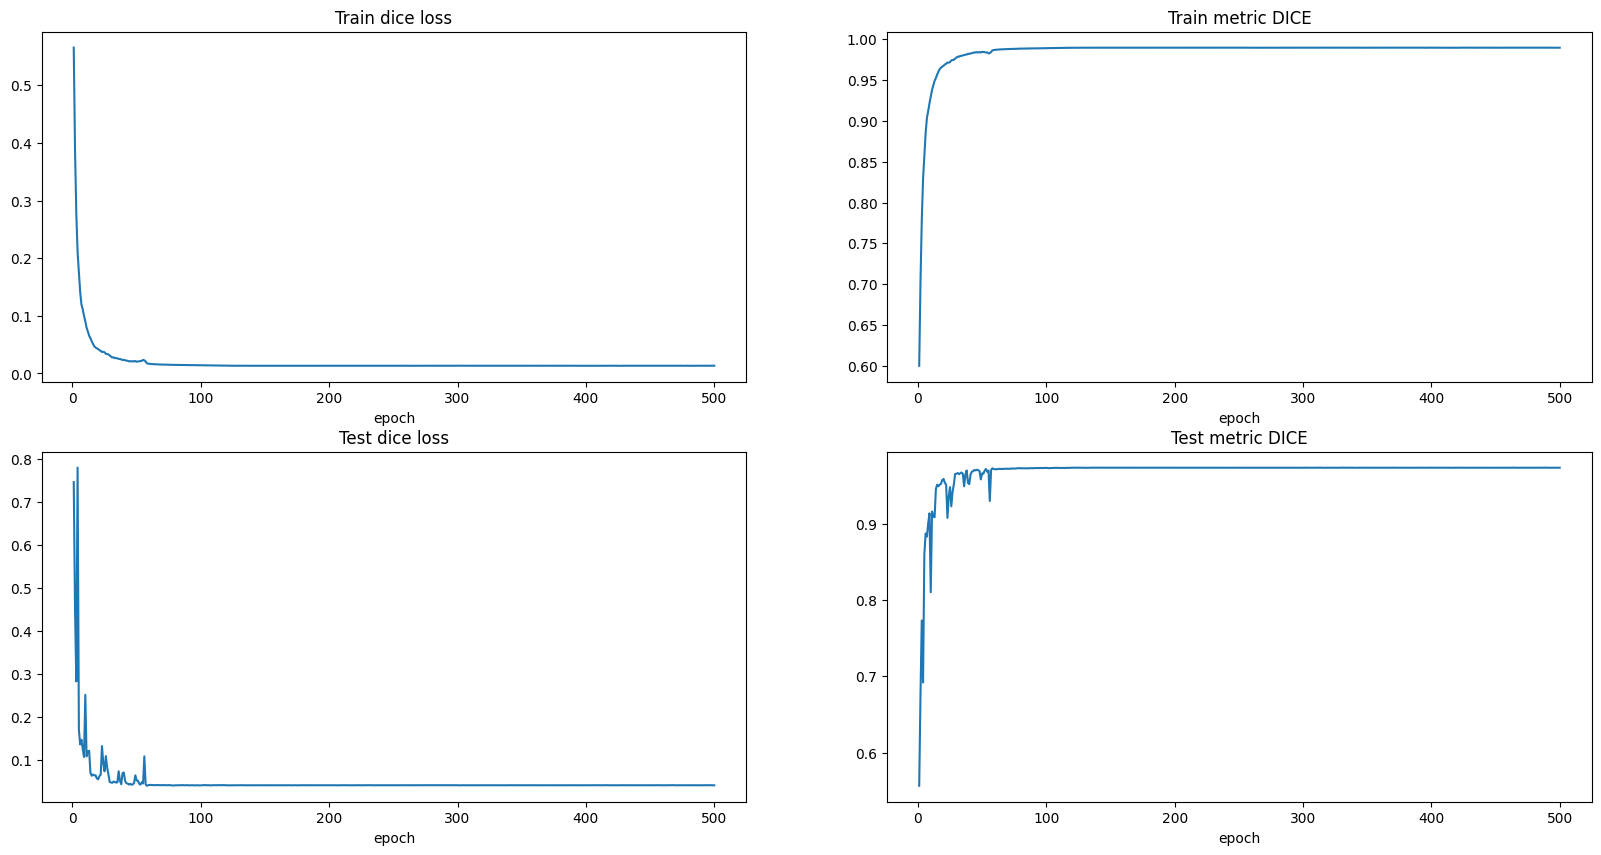

In [21]:
plt.figure("Evaluate", (20, 10))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

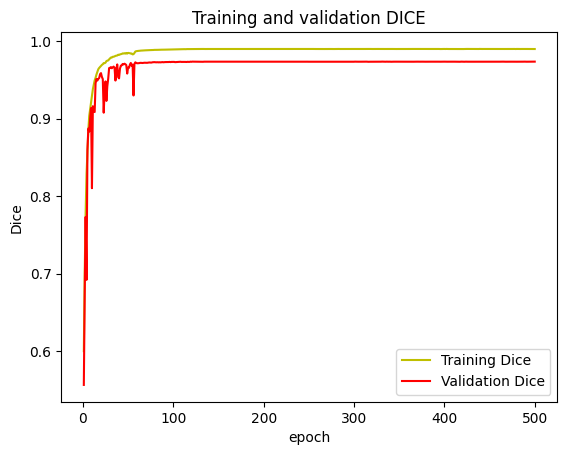

In [22]:
# Plot training and validation dice
plt.title("Training and validation DICE")
dice = train_metric
val_dice = test_metric
epochs = [i + 1 for i in range(len(train_metric))]
plt.plot(epochs, dice, 'y', label='Training Dice')
plt.plot(epochs, val_dice, 'r', label='Validation Dice')
plt.xlabel("epoch")
plt.ylabel("Dice")
plt.legend()
plt.show()

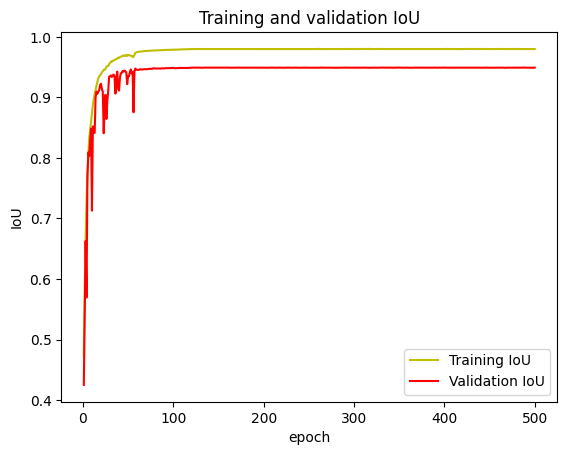

In [23]:
# Plot training and validation IOU
plt.title("Training and validation IoU")
iou = train_iou
val_iou = test_iou
epochs = [i + 1 for i in range(len(train_iou))]
plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.xlabel("epoch")
plt.ylabel("IoU")
plt.legend()
plt.show()

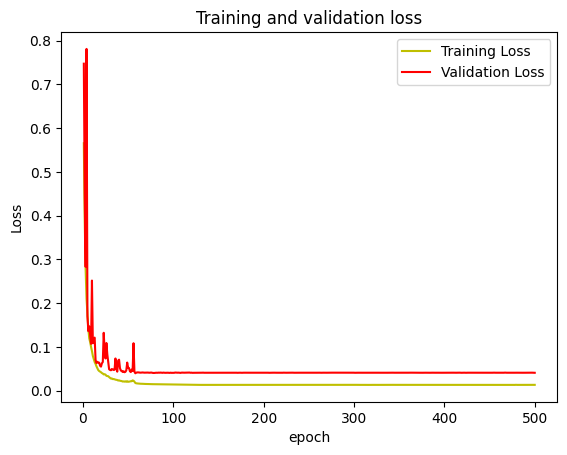

In [24]:
# Plot training and validation loss
plt.title("Training and validation loss")
loss = train_loss
val_loss = test_loss
epochs = [i + 1 for i in range(len(train_loss))]
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
in_dir = data_dir
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSeg", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSeg", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[0:4]

In [20]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.0,1.0,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=1000, a_max=1500,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,128]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [21]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [22]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.BATCH,
    dropout=0.1
).to(device)

In [23]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.1, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.1, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(64

In [24]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.inferers import sliding_window_inference

In [40]:
# Load the best model checkpoint
best_model_path = os.path.join(model_dir, "best_metric_model.pth")
best_model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    norm=Norm.BATCH,
    dropout=0.1
).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

def evaluate(model, dataloader, loss_function, device=torch.device("cuda:0")):
    model.eval()
    total_loss = 0.0
    total_metric = 0.0
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch_data in dataloader:
            inputs = batch_data["vol"].to(device)
            labels = batch_data["seg"].to(device)
            labels = labels != 0  # Assuming binary segmentation

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            total_loss += loss.item()

            # Compute your evaluation metric (e.g., dice coefficient)
            metric = dice_metric(outputs, labels)
            total_metric += metric

            # Compute IoU
            iou = calculate_iou(outputs, labels)
            total_iou += iou

            total_samples += inputs.size(0)

    average_loss = total_loss / total_samples
    average_metric = total_metric / total_samples
    average_iou = total_iou / total_samples

    return average_loss, average_metric, average_iou

# Evaluate the best model on your test data
final_test_loss, final_test_metric, final_test_iou = evaluate(best_model, test_loader, loss_function, device)

# Print the final metrics
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Dice: {final_test_metric:.4f}")
print(f"Final Test IoU: {final_test_iou:.4f}")

Final Test Loss: 0.0409
Final Test Dice: 0.9735
Final Test IoU: 0.9493


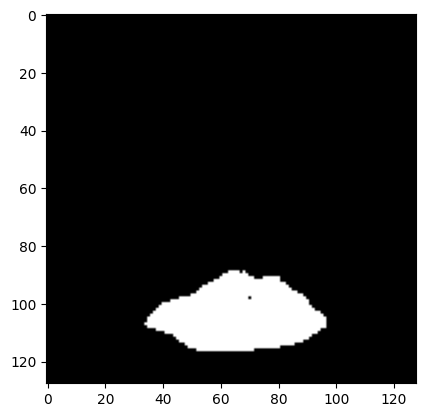

In [ ]:
import nibabel as nib
from torch.cuda.amp import autocast

sw_batch_size = 4
roi_size = (128, 128, 128)

with torch.no_grad(), autocast():
    test_patient = first(test_loader) #
    t_volume = test_patient['vol']
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    # Convert boolean array to integer array
    prediction_array = test_outputs[0, 1].detach().cpu().numpy().astype(np.uint8)

    # Save the prediction as Nifti
    output_nifti = nib.Nifti1Image(prediction_array, affine=np.eye(4))
    nib.save(output_nifti, 'UNet_patient2.nii.gz')
    import matplotlib.pyplot as plt

    # Example visualization
    plt.imshow(prediction_array[:, :, 80], cmap='gray')
    plt.show()
